In [1]:
!unzip /content/PINN-CGM-masterr.zip

Archive:  /content/PINN-CGM-masterr.zip
   creating: PINN-CGM-master/
  inflating: PINN-CGM-master/dataviz.ipynb  
  inflating: PINN-CGM-master/model1.ipynb  
  inflating: PINN-CGM-master/MonitorCGM.txt  
  inflating: __MACOSX/PINN-CGM-master/._MonitorCGM.txt  
  inflating: PINN-CGM-master/MonitorTotalBolus.txt  
  inflating: __MACOSX/PINN-CGM-master/._MonitorTotalBolus.txt  
  inflating: PINN-CGM-master/.gitignore  
  inflating: PINN-CGM-master/preprocess.ipynb  
  inflating: PINN-CGM-master/utils.py  
  inflating: PINN-CGM-master/Evonorm.ipynb  
  inflating: PINN-CGM-master/notes.md  
  inflating: PINN-CGM-master/data.py  
  inflating: PINN-CGM-master/MonitorMeal.txt  
  inflating: __MACOSX/PINN-CGM-master/._MonitorMeal.txt  


In [7]:
%cd PINN-CGM-master

/content/PINN-CGM-master


In [8]:
!python data.py
!python utils.py


In [9]:
!pip install pyswarm
import pyswarm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import numpy as np
from scipy.integrate import odeint
from pyswarm import pso

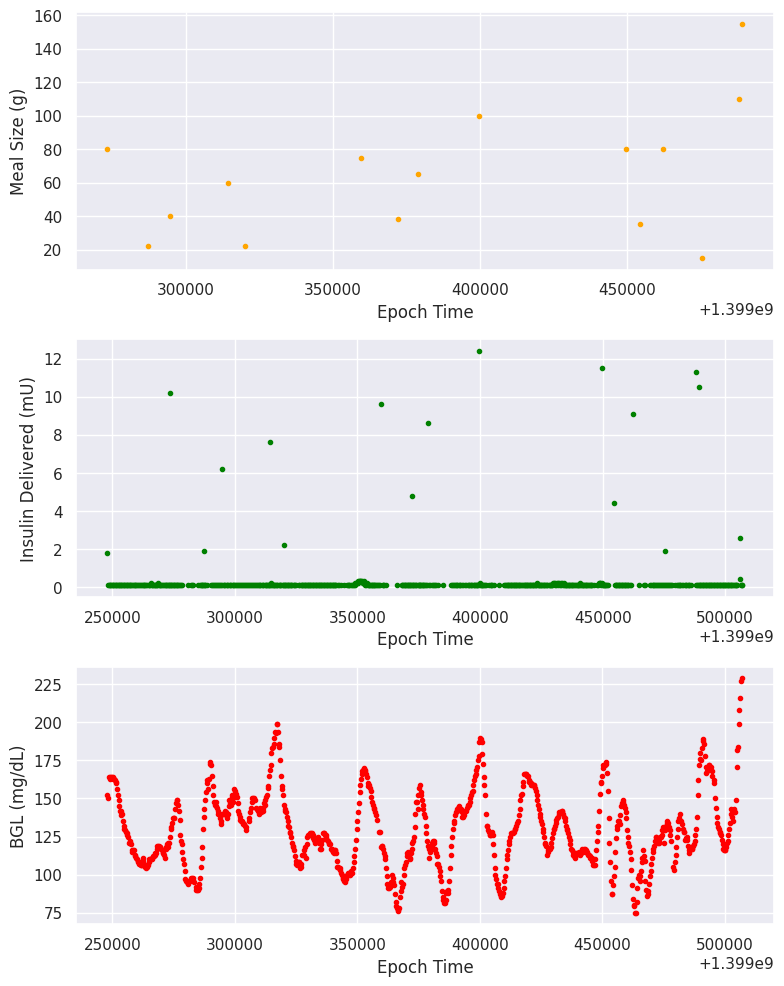

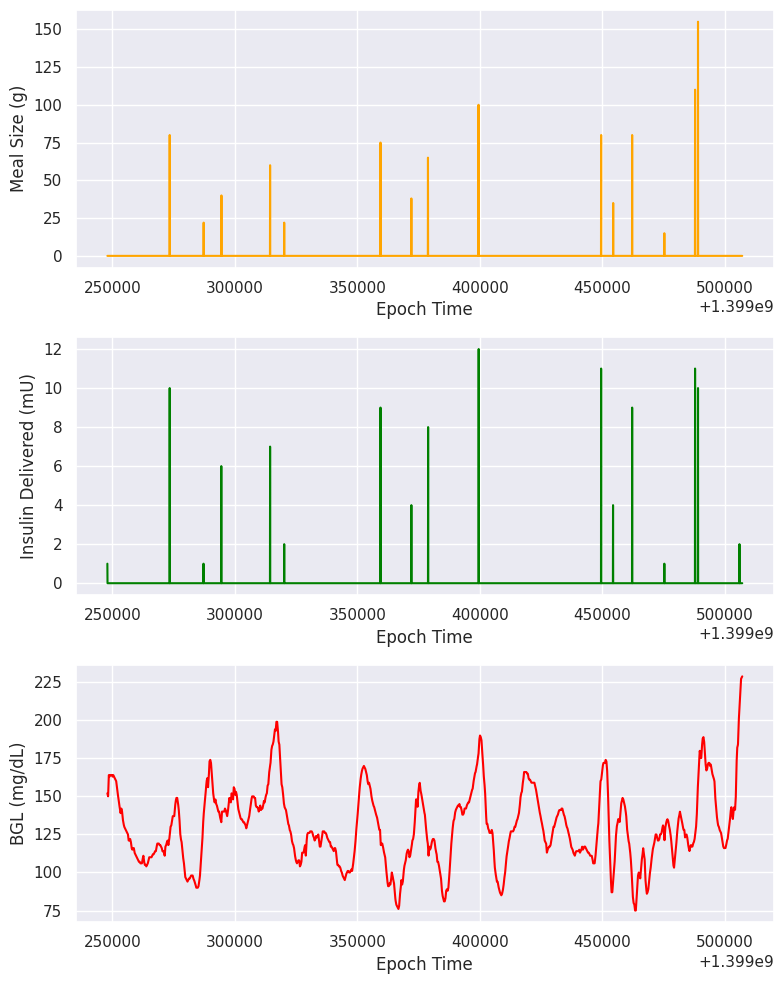

In [11]:
%run "preprocess.ipynb"


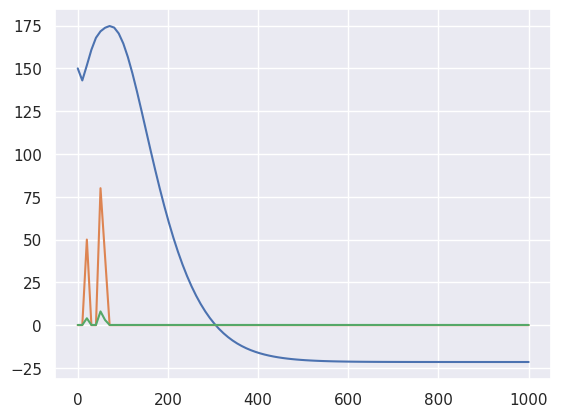

In [12]:
%run "model1.ipynb"


In [13]:
sol['y'].shape

(12, 100)

In [14]:
a = sol['t']
a.shape

(100,)

In [16]:
import numpy as np
from scipy.integrate import odeint
from pyswarm import pso
import random
from scipy.integrate import solve_ivp


In [17]:
def glucose_insulin_model(t, u, p_est, p_fix, t_range, D_t, U_t):

    G_p, G_t, I_l, I_p, I_1, I_d, Q_sto1, Q_sto2, Q_gut, X, I_sc1, I_sc2 = u

    # parameters
    k_p2, k_1, k_2, k_p1, k_i, k_e1, k_max, k_min, k_abs, k_p3, k_gri = p_est
    F_cns, k_e2, f, BW, V_m0, V_mx, K_m0, K_mx, m_2, m_1, m_6, k_a1, m_4, k_a2, V_I, a, b, c, d, p_2U, I_b, k_d = p_fix

    # noise
    δ = np.random.normal(0, 1)

    # meal intake
    D = D_t[np.abs(t_range - t).argmin()]

    # insulin infusion rate
    U = U_t[np.abs(t_range - t).argmin()]

    dG_p = k_p1 - F_cns - (k_1 * G_p) + (k_2 * G_t) - (k_p2 * G_p) - (k_p3 * I_d) + (k_e1 * (k_e2 - G_p)) + ((f * k_abs * Q_gut)/BW)
    dG_t = (k_1 * G_p) - (k_2 * G_t) - ((G_t * (V_m0 + (V_mx * X))) / (K_m0 + G_t + (K_mx * X)))
    dI_l = (m_2 * I_p) - I_l * (m_1 - ((m_1 * m_6) / (m_6 - 1)))
    dI_p = (k_a1 * I_sc1) - (I_p * (m_2 + m_4)) + (k_a2 * I_sc2) + (m_1 * I_l)
    dI_1 = -k_i * (I_1 - (I_p / V_I))
    dI_d = k_i * (I_1 - I_d)
    dQ_sto1 = (-k_gri * Q_sto1) + D * δ
    dQ_sto2 = (k_gri * Q_sto1) - Q_sto2 * (k_min + ((k_max / 2) - (k_min / 2)) * (np.tanh(a * (Q_sto1 + Q_sto2 - (b * D))) - np.tanh(c * (Q_sto1 + Q_sto2 - (d * D))) + 2))
    dQ_gut = Q_sto2 * (k_min + ((k_max / 2) - (k_min / 2)) * (np.tanh(a * (Q_sto1 + Q_sto2 - (b * D))) - np.tanh(c * (Q_sto1 + Q_sto2 - (d * D))) + 2)) - (k_abs * Q_gut)
    dX = -p_2U * (I_b - (I_p / V_I)) - (p_2U * X)
    dI_sc1 = U - (I_sc1 * (k_a1 + k_d))
    dI_sc2 = (k_d * I_sc1) - (k_a2 * I_sc2)

    return [dG_p, dG_t, dI_l, dI_p, dI_1, dI_d, dQ_sto1, dQ_sto2, dQ_gut, dX, dI_sc1, dI_sc2]

In [88]:
from sklearn.metrics import mean_squared_error
def fitness(params):
    # inputs
    t_span = (0, 1000)
    t_range = np.linspace(*t_span, 4320)
    D_t = np.zeros_like(t_range)
    U_t = 0.1 * np.ones_like(t_range)

    D_t[np.abs(t_range - 20).argmin()] = 50
    D_t[np.abs(t_range - 50).argmin()] = 80
    D_t[np.abs(t_range - 60).argmin()] = 40

    U_t[np.abs(t_range - 20).argmin()] = 4
    U_t[np.abs(t_range - 50).argmin()] = 8
    U_t[np.abs(t_range - 60).argmin()] = 3



    # fixed parameters
    F_cns = 1
    k_e2 = 339
    f = 0.90
    BW = 60
    V_m0 = 2.50
    V_mx = 0.047
    K_m0 = 225.59
    K_mx = 0.0 # ?
    m_2 = 0.484
    m_1 = 0.190
    m_6 = 0.6471
    k_a1 = 0.0018
    m_4 = 0.194
    k_a2 = 0.0182
    V_I = 0.05
    a = 0.000013
    b = 0.82
    c = 0.00236
    d = 0.01
    p_2U = 0.0331
    I_b = 25.49
    k_d = 0.0164
    p_fix = [F_cns, k_e2, f, BW, V_m0, V_mx, K_m0, K_mx, m_2, m_1, m_6, k_a1, m_4, k_a2, V_I, a, b, c, d, p_2U, I_b, k_d]

    # parameters to estimate
    k_p2 = 0.0021
    k_1 = 0.065
    k_2 = 0.079
    k_p1 = 2.70
    k_i = 0.0079
    k_e1 = 0.0005
    k_max = 0.0558
    k_min = 0.0080
    k_abs = 0.057
    k_p3 = 0.009
    k_gri = 0.0558
    p_est = [k_p2, k_1, k_2, k_p1, k_i, k_e1, k_max, k_min, k_abs, k_p3, k_gri]

    # initial conditions
    G_p_0 = 100.0
    G_t_0 = 20.0
    I_l_0 = 1.0
    I_p_0 = 1.0
    I_1_0 = 25.49 # ?
    I_d_0 = 25.49 # ?
    Q_sto1_0 = 100.0
    Q_sto2_0 = 100.0
    Q_gut_0 = 100.0
    X_0 = 150 # ?
    I_sc1_0 = 500.0
    I_sc2_0 = 200.0
    
    u0 = [G_p_0, G_t_0, I_l_0, I_p_0, I_1_0, I_d_0, Q_sto1_0, Q_sto2_0, Q_gut_0, X_0, I_sc1_0, I_sc2_0]
    # print("hello1")
    ode_sol = solve_ivp(lambda t, y: glucose_insulin_model(t, y, p_est, p_fix, t_range, D_t, U_t), t_span, u0, t_eval=t_range, method="BDF")
    # print("hello2")
    X_model = ode_sol['t']
    G_model = ode_sol['y'][0]

    # print(G_model.shape)
    # print(X_model.shape)
    G_actual = cgm_interp
    # print(G_actual.shape)
    X_actual = t_interp
    # print(X_actual.shape)

    SSE_G = mean_squared_error(G_model, G_actual)
    # print("hello4")
    SSE_X = mean_squared_error(X_model, X_actual)
    # print("hello5")
    fitness_value = SSE_G + SSE_X
    # print("hello6")
    return fitness_value

In [89]:
t_span = (0, 1000)
t_range = np.linspace(*t_span, 4320)
D_t = np.zeros_like(t_range)
U_t = 0.1 * np.ones_like(t_range)

D_t[np.abs(t_range - 20).argmin()] = 50
D_t[np.abs(t_range - 50).argmin()] = 80
D_t[np.abs(t_range - 60).argmin()] = 40

U_t[np.abs(t_range - 20).argmin()] = 4
U_t[np.abs(t_range - 50).argmin()] = 8
U_t[np.abs(t_range - 60).argmin()] = 3

In [90]:
X_actual = t_interp
G_actual = cgm_interp


In [91]:
# Define the parameter space
parameter_space = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

# Run the PSO algorithm
fittest_individual, fittest_individual_fitness = pso(fitness, lb=np.array([p[0] for p in parameter_space]), ub=np.array([p[1] for p in parameter_space]), swarmsize=100, maxiter=100)


Stopping search: maximum iterations reached --> 100


In [78]:

print("Fittest individual: ", fittest_individual)
print("Fittest individual fitness: ", fittest_individual_fitness)

Fittest individual:  [0.6818806  0.47257172 0.53133937 0.12494827 0.36067875 0.55327951
 0.56191835 0.90824363 0.03167497 0.36440657 0.59611752]
Fittest individual fitness:  8.459666811604411e+21


array([0, 0, 0, ..., 0, 0, 0])

In [79]:
def estimate_glucose_concentration(fittest_individual):

    # Solve the Dall-Model using the given parameters and initial conditions
    # ode_sol = odeint(glucose_insulin_model, u0, t_range, args=(fittest_individual))
    ode_sol = solve_ivp(lambda t, y: glucose_insulin_model(t, y, fittest_individual, p_fix, t_range, D_t, U_t), t_span, u0, t_eval=t_range, method="BDF")

    G_model = ode_sol['y'][0] # Predicted glucose concentration
    X_model = ode_sol['t']
    return G_model, X_model

In [80]:
G_predicted, t  = estimate_glucose_concentration(fittest_individual)


In [81]:
G_predicted

array([100.        , 103.74086876, 107.04200543, ..., 149.53592963,
       149.5359297 , 149.53592977])

In [82]:
cgm_interp

array([152.        , 151.59866221, 151.19732441, ..., 228.42666667,
       228.62666667, 228.82666667])

In [ ]:
plt.plot(t_interp, G_predicted, label='Predicted glucose concentration')
plt.plot(t_interp, G_actual, 'r', label='Actual glucose concentration')
plt.xlabel('Time (min)')
plt.ylabel('Glucose concentration (mg/dL)')
plt.legend()
plt.show()

In [ ]:
from utils import visualize
visualize(
    (t_interp, cgm_iterp), 
    (t_interp, meal_interp), 
    (t_interp, insulin_interp), 
    fmt="-",
)